In [65]:
import os
import numpy as np
from numba import jit
from scipy.io import loadmat
from scipy.stats import pearsonr
from scipy.signal import convolve
from spattemp.functions import *
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd

rng = np.random.default_rng()
plt.style.use("default")
sns.set(context="talk")

In [78]:
def ln_model_fitted_gaussian(
        running_stimuli,
        frozen_stimuli,
        running_responses,
        frozen_responses,
        stas,
        kernel_size,
        sta_window,
        fit_func,
        fit_bounds=(-np.inf, np.inf),
):
    total_cells = running_responses.shape[0]
    output_dict = {
        "cell_id": [],
        "ln_fit_params": [],
        "r_value": [],
        "gauss_fit_params": [],
    }

    x = np.arange(0, sta_window * 2)
    y = np.arange(0, sta_window * 2)
    xx, yy = np.meshgrid(x, y)
    xdata = np.vstack((xx.ravel(), yy.ravel()))
    initial_guesses = (1., sta_window, sta_window, *5*np.eye(2).ravel())

    for cell_id in tqdm(range(total_cells), desc="Cell"):
        response_to_running = running_responses[cell_id]

        cell_sta = stas[cell_id]
        cell_mis_pos = get_mis_pos(cell_sta)
        mis_t, mis_y, mis_x = cell_mis_pos

        spatial_kernel, temporal_kernel = get_spat_temp_kern(cell_sta, cell_mis_pos, sta_window)

        kern_to_fit = spatial_kernel.ravel()
        gaussian_params, _ = curve_fit(gauss_2d, xdata, kern_to_fit, p0=initial_guesses)

        fitted_gaussian = gauss_2d(xdata, *gaussian_params)

        running_convolved = convolve_stimulus_with_kernels(
            stimulus=running_stimuli,
            spatial_kernel=fitted_gaussian,
            temporal_kernel=temporal_kernel,
            total_trials=running_responses.shape[1],
            sta_x=mis_x,
            sta_y=mis_y,
            sta_window=sta_window,
        )

        fit_params = fit_non_linearity(running_convolved, response_to_running, fit_func, fit_bounds)

        response_to_frozen = frozen_responses[cell_id]

        frozen_convolved = convolve_stimulus_with_kernels(
            stimulus=frozen_stimuli,
            spatial_kernel=fitted_gaussian,
            temporal_kernel=temporal_kernel,
            total_trials=1,
            sta_x=mis_x,
            sta_y=mis_y,
            sta_window=sta_window,
        )[0]

        fitted_nonlinearity = fit_func(frozen_convolved, *fit_params)

        ground_truth = np.mean(response_to_frozen, axis=0)[kernel_size - 1:]

        r_value, p_value = pearsonr(ground_truth, fitted_nonlinearity)

        output_dict["cell_id"].append(cell_id)
        output_dict["ln_fit_params"].append(fit_params)
        output_dict["r_value"].append(r_value)
        output_dict["gauss_fit_params"].append(gaussian_params)

    return output_dict


def ln_model(
        running_stimuli,
        frozen_stimuli,
        running_responses,
        frozen_responses,
        stas,
        kernel_size,
        sta_window,
        fit_func,
        fit_bounds=(-np.inf, np.inf),
):
    total_cells = running_responses.shape[0]
    output_dict = {
        "cell_id": [],
        "ln_fit_params": [],
        "r_value": [],
    }

    for cell_id in tqdm(range(total_cells), desc="Cell"):
        response_to_running = running_responses[cell_id]

        cell_sta = stas[cell_id]
        cell_mis_pos = get_mis_pos(cell_sta)
        mis_t, mis_y, mis_x = cell_mis_pos

        spatial_kernel, temporal_kernel = get_spat_temp_kern(cell_sta, cell_mis_pos, sta_window)

        running_convolved = convolve_stimulus_with_kernels(
            stimulus=running_stimuli,
            spatial_kernel=spatial_kernel,
            temporal_kernel=temporal_kernel,
            total_trials=running_responses.shape[1],
            sta_x=mis_x,
            sta_y=mis_y,
            sta_window=sta_window,
        )

        fit_params = fit_non_linearity(running_convolved, response_to_running, fit_func, fit_bounds)

        response_to_frozen = frozen_responses[cell_id]

        frozen_convolved = convolve_stimulus_with_kernels(
            stimulus=frozen_stimuli,
            spatial_kernel=spatial_kernel,
            temporal_kernel=temporal_kernel,
            total_trials=1,
            sta_x=mis_x,
            sta_y=mis_y,
            sta_window=sta_window,
        )[0]

        fitted_nonlinearity = fit_func(frozen_convolved, *fit_params)

        ground_truth = np.mean(response_to_frozen, axis=0)[kernel_size - 1:]

        r_value, p_value = pearsonr(ground_truth, fitted_nonlinearity)

        output_dict["cell_id"].append(cell_id)
        output_dict["ln_fit_params"].append(fit_params)
        output_dict["r_value"].append(r_value)

    return output_dict


def fit_non_linearity(convolved_signal, response, fit_func, fit_bounds):
    cs_size = convolved_signal.shape[-1]
    fit_params, _ = curve_fit(fit_func, convolved_signal.ravel(), response[:, -cs_size:].ravel(), bounds=fit_bounds)

    return fit_params


def convolve_stimulus_with_kernels(stimulus, spatial_kernel, temporal_kernel, total_trials, sta_x, sta_y, sta_window):
    convolved_response = np.zeros((total_trials, stimulus.shape[1] - temporal_kernel.size + 1))
    for tr, trial in enumerate(stimulus[:total_trials]):
        trial = trial[:, sta_y - sta_window:sta_y + sta_window, sta_x - sta_window:sta_x + sta_window]
        trial = trial.reshape((trial.shape[0], trial.shape[1] * trial.shape[2]))
        # temp_conv = np.zeros((spatial_kernel.size, trial.shape[1] - temporal_kernel.size + 1))
        # for p, pixel in enumerate(trial):
        #     temp_conv[p] = np.convolve(pixel, temporal_kernel, mode="valid")
        temp_conv = convolve(trial, np.expand_dims(temporal_kernel, axis=-1), mode="valid")
        inner_sum = spatial_kernel * temp_conv
        spat_conv = inner_sum.mean(axis=-1)
        convolved_response[tr] = spat_conv
    return convolved_response


def get_predicted_response(convolved_signal, conv_sig_values, avg_resp_counts, method="average", fit_func=None):
    if not conv_sig_values.size == avg_resp_counts.size:
        raise AttributeError("Convolved signal values and response counts should be of the same length")
    dig_conv_sig = np.digitize(convolved_signal, conv_sig_values)
    if method == "greater":
        return np.array([avg_resp_counts[i] for i in dig_conv_sig])
    elif method == "lesser":
        return np.array([avg_resp_counts[i-1] for i in dig_conv_sig])
    elif method == "average":
        return np.array([(avg_resp_counts[i] + avg_resp_counts[i-1]) / 2 for i in dig_conv_sig])
    elif method == "fit":
        if fit_func is not None:
            params, _ = curve_fit(fit_func, conv_sig_values, avg_resp_counts)
            return fit_func(convolved_signal, *params)
        else:
            raise ValueError("fit_func must be provided for the \"fit\" method!")
    else:
        raise ValueError("Invalid method requested! Choose between greater, lesser and average.")


def dimos_model(x, b, m, r, g):
    first = (m - b) / (1 + np.exp(-r * (x - g)))
    return b + first


def softmax_model(x, a1, a2, a3):
    return a1 * np.log(1 + np.exp(a2 * (x + a3)))


@jit
def gauss_2d(x, a, mu1, mu2, s11, s12, s21, s22):
    results = np.zeros(x.shape[1])

    sigma = np.array([[s11, s12], [s21, s22]])
    sigma_inv = np.linalg.inv(sigma)
    s11_, s12_, s21_, s22_ = sigma_inv[0, 0], sigma_inv[0, 1], sigma_inv[1, 0], sigma_inv[1, 1]
    sigma_det = np.linalg.det(sigma)

    norm = a / (2 * np.pi * np.sqrt(sigma_det))

    for i, (x1, x2) in enumerate(x.T):
        exp = s11_ * (x1 - mu1) ** 2 + s22_ * (x2 - mu2) ** 2 + \
            (s12_ + s21_) * (x1 - mu1) * (x2 - mu2)
        results[i] = norm * np.exp(-exp / 2)

    return results


def fit_gauss2d(spatial_kernel, sta_window):
    x = np.arange(0, sta_window * 2)
    y = np.arange(0, sta_window * 2)
    xx, yy = np.meshgrid(x, y)
    xdata = np.vstack((xx.ravel(), yy.ravel()))

    initial_guesses = (1., sta_window, sta_window, *5*np.eye(2).ravel())
    to_fit = spatial_kernel.ravel()

    # Do the fit!
    fit_params, _ = curve_fit(gauss_2d, xdata, to_fit, p0=initial_guesses)
    fitted_gaussian = gauss_2d(xdata, *fit_params)

    return fit_params, fitted_gaussian


def plot_fitted_gauss2d(spatial_kernel, fit_params, sta_window):
    x = np.arange(0, sta_window * 2)
    y = np.arange(0, sta_window * 2)
    xx, yy = np.meshgrid(x, y)
    xdata = np.vstack((xx.ravel(), yy.ravel()))

    fitted_gaussian = gauss_2d(xdata, *fit_params)

    original = spatial_kernel / np.linalg.norm(spatial_kernel)
    fitted = fitted_gaussian / np.linalg.norm(fitted_gaussian)

    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
    cmap = cm.get_cmap('inferno')
    normalizer = Normalize(min(original.min(), fitted.min()), max(original.max(), fitted.max()))
    ax[0].imshow(original.reshape(sta_window * 2, sta_window * 2), cmap=cmap, norm=normalizer)
    ax[0].set_title("Original")
    ax[1].imshow(fitted.reshape(sta_window * 2, sta_window * 2), cmap=cmap, norm=normalizer)
    ax[1].set_title("Gaussian Fit")
    for a in ax.flat:
        a.grid(False)

    return fig


def save_all_gauss_fit_plots(sta_array, output_df, sta_window, save_folder):
    if not os.path.exists(save_folder):
        print("Folder does not exist! Creating it!")
        os.makedirs(save_folder, exist_ok=True)

    for idx, row in tqdm(output_df.iterrows(), total=len(output_df), desc="Cells"):
        cell_id = row["cell_id"]
        gauss_params = row["gauss_fit_params"]
        sta = sta_array[cell_id]
        spat_kern, _ = get_spat_temp_kern(sta, get_mis_pos(sta), sta_window)

        fig = plot_fitted_gauss2d(spat_kern, gauss_params, sta_window)
        fig.suptitle(f"Cell {cell_id}", y=0.85)
        plt.savefig(os.path.join(save_folder, f"GaussFit_Cell_{cell_id}.png"), bbox_inches='tight')
        plt.close()

In [3]:
stimuli_path = "./stimuli_npy"
stas_path = "./stas"
datasets_path = "./cell_data"

In [34]:
dataset = "cell_data_01_NC"
kernel_size = 25
sta_window = 25

In [35]:
sta_file = os.path.join(stas_path, dataset + f"_stas_{kernel_size}.npy")
stas = np.load(sta_file)

In [36]:
data = loadmat(os.path.join(datasets_path, dataset) + ".mat")
running, frozen = data["spk1"], data["spk2"]
running = np.transpose(running, (0, 2, 1))
frozen = np.transpose(frozen, (0, 2, 1))

In [37]:
stimuli = np.load(os.path.join(stimuli_path, "running_stimuli.npy"), mmap_mode="r")
frozen_stimuli = np.load(os.path.join(stimuli_path, "frozen_stimuli.npy"))
frozen_stimuli = np.expand_dims(frozen_stimuli, axis=0)

In [38]:
height, width = stimuli.shape[-2], stimuli.shape[-1]

In [39]:
print("(#cells, #bins, #height, #width)")
print(stas.shape)

(#cells, #bins, #height, #width)
(78, 25, 150, 200)


In [40]:
print("(#cells, #trials, #bins)")
print(running.shape)
print(frozen.shape)

(#cells, #trials, #bins)
(78, 219, 1500)
(78, 219, 300)


In [41]:
print("(#trials, #bins, #height, #width)")
print(stimuli.shape)

(#trials, #bins, #height, #width)
(300, 1500, 150, 200)


In [82]:
results = ln_model_fitted_gaussian(
    running_stimuli=stimuli,
    frozen_stimuli=frozen_stimuli,
    running_responses=running,
    frozen_responses=frozen,
    stas=stas,
    sta_window=sta_window,
    fit_func=softmax_model,
    fit_bounds=([0.0, 1000.0, -1.0],
                [1000.0, 20000.0, 1.0]),
    kernel_size=kernel_size
)

Cell:   0%|          | 0/78 [00:00<?, ?it/s]

In [83]:
results.keys()

dict_keys(['cell_id', 'ln_fit_params', 'r_value', 'gauss_fit_params'])

In [84]:
results_df = pd.DataFrame(results)

In [85]:
print(f"Mean r_value is {results_df.r_value.mean()}")

Mean r_value is 0.37231594538512924


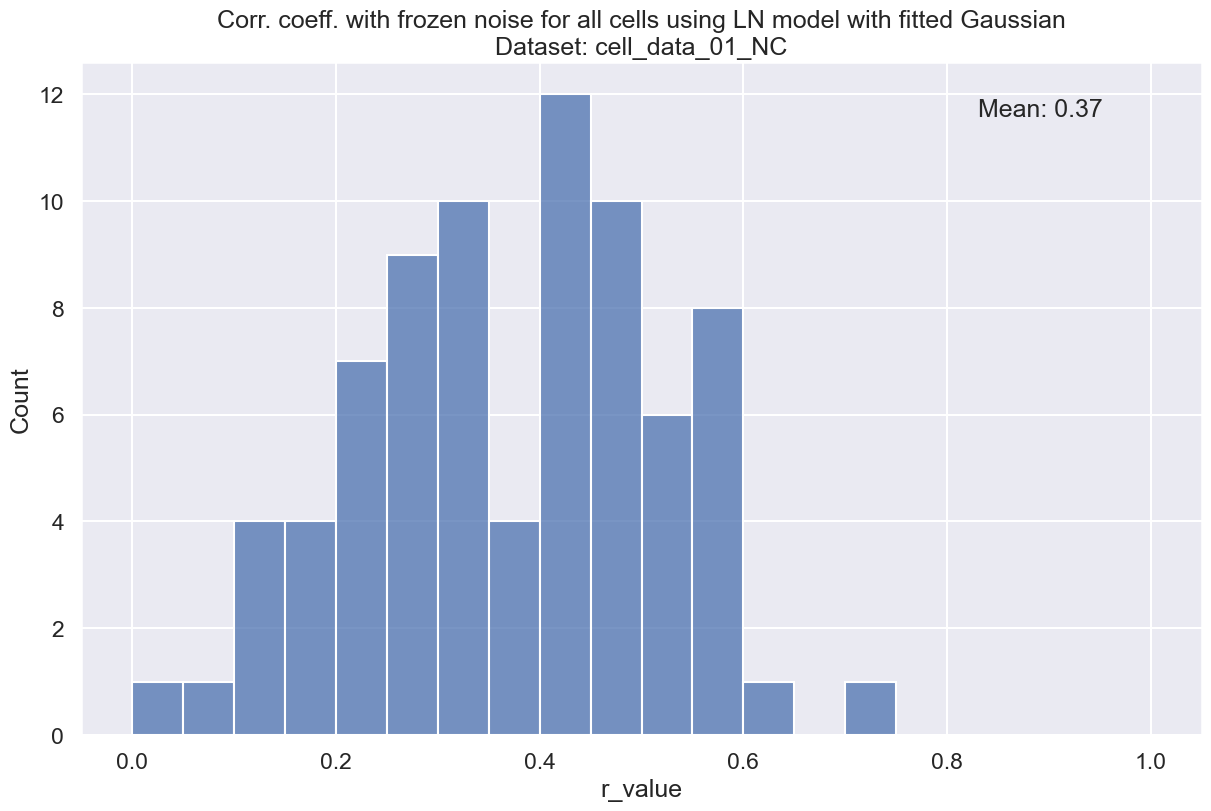

In [86]:
fig, axis = plt.subplots(figsize=(12, 8), layout="constrained")
plot = sns.histplot(results_df["r_value"], binrange=(0.0, 1.0), bins=20, ax=axis)
plot.set_title(f"Corr. coeff. with frozen noise for all cells using LN model with fitted Gaussian\nDataset: {dataset}")
plot.text(0.8, 0.92, f"Mean: {results_df.r_value.mean():.2f}", transform=plot.transAxes)
plt.savefig(f"./prediction_plots/{dataset}/ln_model/with_gauss/r_value_dist_{dataset}.png")
plt.show()

In [87]:
results_ln = ln_model(
    running_stimuli=stimuli,
    frozen_stimuli=frozen_stimuli,
    running_responses=running,
    frozen_responses=frozen,
    stas=stas,
    sta_window=sta_window,
    fit_func=softmax_model,
    fit_bounds=([0.0, 1000.0, -1.0],
                [1000.0, 20000.0, 1.0]),
    kernel_size=kernel_size
)

Cell:   0%|          | 0/78 [00:00<?, ?it/s]

In [88]:
results_ln_df = pd.DataFrame(results_ln)

In [89]:
print(f"Mean r_value is {results_ln_df.r_value.mean()}")

Mean r_value is 0.29908385110877866


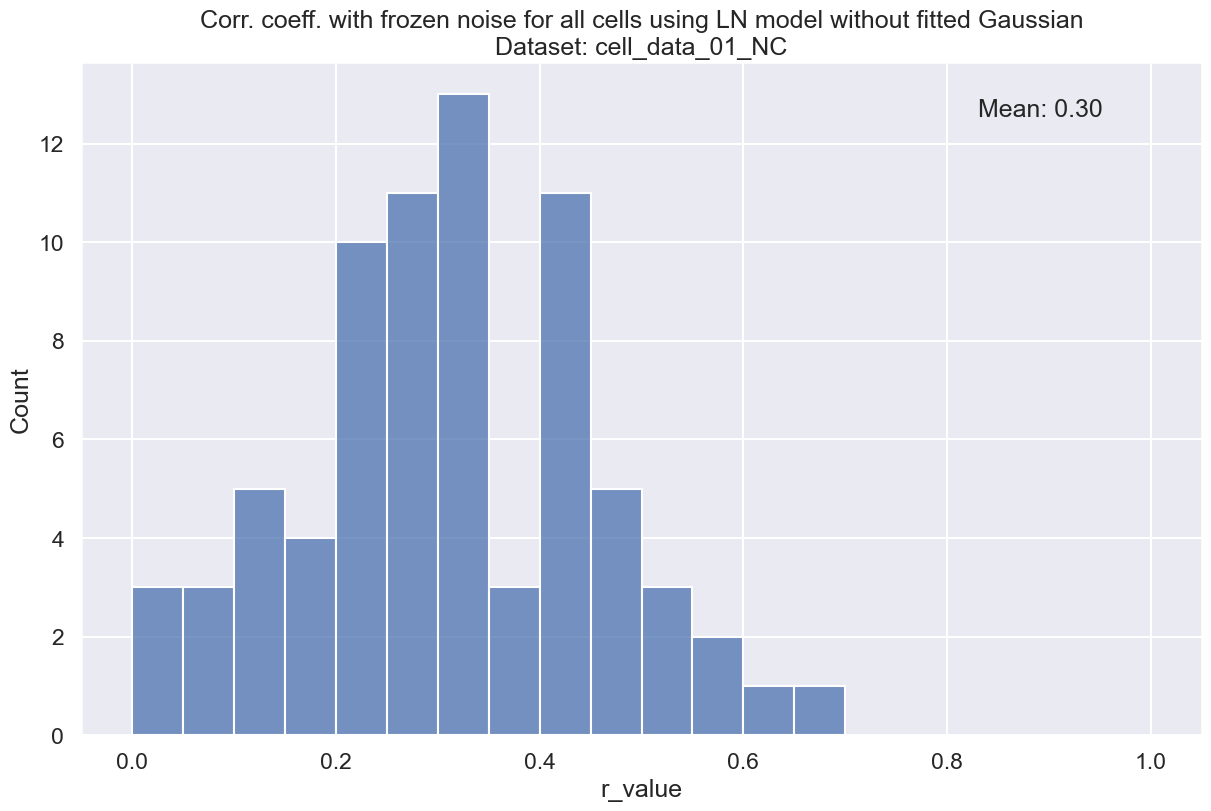

In [90]:
fig, axis = plt.subplots(figsize=(12, 8), layout="constrained")
plot = sns.histplot(results_ln_df["r_value"], binrange=(0.0, 1.0), bins=20, ax=axis)
plot.set_title(f"Corr. coeff. with frozen noise for all cells using LN model without fitted Gaussian\nDataset: {dataset}")
plot.text(0.8, 0.92, f"Mean: {results_ln_df.r_value.mean():.2f}", transform=plot.transAxes)
plt.savefig(f"./prediction_plots/{dataset}/ln_model/without_gauss/r_value_dist_{dataset}.png")
plt.show()

In [96]:
pd.to_pickle(results_df, f"./prediction_plots/{dataset}/ln_model/with_gauss/results.pkl")

In [97]:
pd.to_pickle(results_ln_df, f"./prediction_plots/{dataset}/ln_model/without_gauss/results.pkl")

In [91]:
compare_results_df = pd.DataFrame({"LN_no_gauss_fit": results_ln_df.r_value, "LN_with_gauss_fit": results_df.r_value})

In [92]:
compare_results_df

,LN_no_gauss_fit,LN_with_gauss_fit
0,0.282021,0.298080
1,-0.007377,0.475500
2,0.128487,0.198296
3,0.066399,0.104750
4,0.442766,0.513172
...,...,...
73,0.233502,0.130537
74,0.436386,0.513679
75,0.264750,0.564891
76,0.172516,0.391277


In [93]:
wideform_compare_df = pd.melt(compare_results_df, value_vars=["LN_no_gauss_fit", "LN_with_gauss_fit"], var_name="model", value_name="r_value")

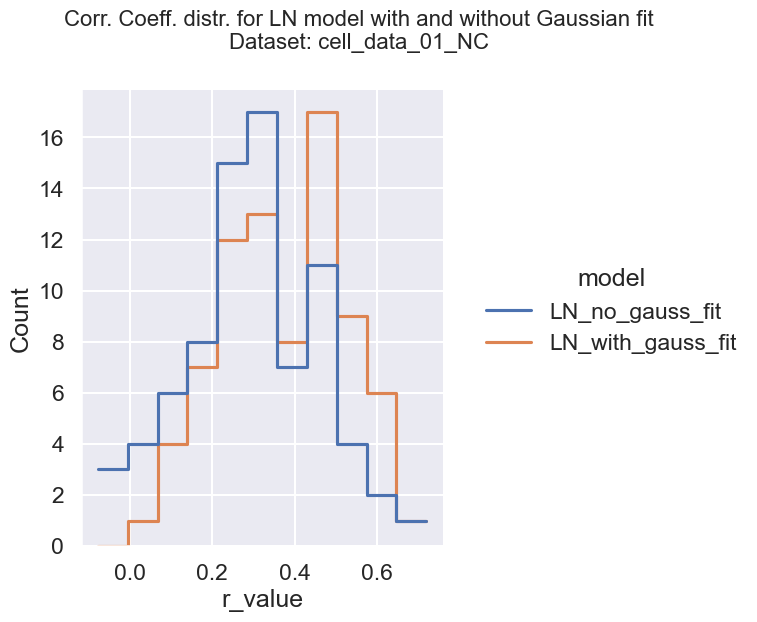

In [101]:
f = sns.displot(wideform_compare_df, x="r_value", hue="model", element="step", fill=False)
f.figure.set(size_inches=(8, 6))
f.figure.suptitle(f"Corr. Coeff. distr. for LN model with and without Gaussian fit\nDataset: {dataset}", y=1.08, size=16)
plt.savefig(f"./prediction_plots/{dataset}/compare_ln_lng_r_values.png", bbox_inches='tight')
plt.show()

In [55]:
chosen_cell = results_ln_df.loc[np.where(results_ln_df.r_value == results_ln_df.r_value.min())[0]]

In [56]:
chosen_cell

,cell_id,ln_fit_params,r_value
46,46,"[289.36195751488657, 1914.3356468483944, -0.00...",-0.077916


In [147]:
selected_cell_id = chosen_cell['cell_id'].item()
selected_gauss_fit_params = chosen_cell['gauss_fit_params'].item()
selected_ln_fit_params = chosen_cell['ln_fit_params'].item()

In [148]:
selected_sta = stas[selected_cell_id]

In [149]:
s_spat_kern, s_temp_kern = get_spat_temp_kern(selected_sta, get_mis_pos(selected_sta), sta_window)

In [14]:
fig = plot_fitted_gauss2d(s_spat_kern, selected_gauss_fit_params, sta_window)
fig.suptitle(f"Cell {selected_cell_id}", y=0.85)
plt.show()

NameError: name 's_spat_kern' is not defined

In [95]:
save_all_gauss_fit_plots(stas, results_df, sta_window, f"./prediction_plots/{dataset}/ln_model/with_gauss/gauss_fit/")

Cells:   0%|          | 0/78 [00:00<?, ?it/s]

In [58]:
x = np.arange(0, sta_window * 2)
y = np.arange(0, sta_window * 2)
xx, yy = np.meshgrid(x, y)
xdata = np.vstack((xx.ravel(), yy.ravel()))
initial_guesses = (1., sta_window, sta_window, *5*np.eye(2).ravel())

In [81]:
for cell_id in tqdm(range(running.shape[0]), desc="Cell"):
    response_to_running = running[cell_id]

    cell_sta = stas[cell_id]
    cell_mis_pos = get_mis_pos(cell_sta)
    mis_t, mis_y, mis_x = cell_mis_pos

    spatial_kernel, temporal_kernel = get_spat_temp_kern(cell_sta, cell_mis_pos, sta_window)

    # kern_to_fit = spatial_kernel.ravel()
    # gaussian_params, _ = curve_fit(gauss_2d, xdata, kern_to_fit, p0=initial_guesses)
    #
    # fitted_gaussian = gauss_2d(xdata, *gaussian_params)

    running_convolved = convolve_stimulus_with_kernels(
        stimulus=stimuli,
        spatial_kernel=spatial_kernel,
        temporal_kernel=temporal_kernel,
        total_trials=running.shape[1],
        sta_x=mis_x,
        sta_y=mis_y,
        sta_window=sta_window,
    )

    fit_params = fit_non_linearity(running_convolved, response_to_running, softmax_model, fit_bounds=([0.0, 1000.0, -1.0], [1000.0, 20000.0, 1.0]))

    response_to_frozen = frozen[cell_id]

    frozen_convolved = convolve_stimulus_with_kernels(
        stimulus=frozen_stimuli,
        spatial_kernel=spatial_kernel,
        temporal_kernel=temporal_kernel,
        total_trials=1,
        sta_x=mis_x,
        sta_y=mis_y,
        sta_window=sta_window,
    )[0]

    fitted_nonlinearity = softmax_model(frozen_convolved, *fit_params)

    ground_truth = np.mean(response_to_frozen, axis=0)[kernel_size - 1:]

    r_value, p_value = pearsonr(ground_truth, fitted_nonlinearity)

    xlist = np.arange(kernel_size - 1, frozen_stimuli.shape[1])

    fig, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)
    p1, = ax.plot(xlist, fitted_nonlinearity, label="LN Model")
    p2, = ax.plot(xlist, ground_truth, ls='--', label="Ground Truth")

    ax.set_xlabel("Time (bins)")
    ax.set_ylabel("Response counts")
    ax.set_title(f"LN model prediction for cell {cell_id} in dataset {dataset}\nPearson's R: {r_value:.2f}")
    ax.legend(handles=[p1, p2])
    ax.grid(True)
    plt.savefig(f"./prediction_plots/{dataset}/ln_model/without_gauss/frozen_corr/{cell_id}.png")
    plt.close()

Cell:   0%|          | 0/78 [00:00<?, ?it/s]

In [44]:
cell_id = 63
cell_response = running[cell_id]

In [45]:
if os.path.exists(sta_file):
    stas = np.load(sta_file, mmap_mode="r")
    sta = stas[cell_id]
else:
    # calculate STA
    sta = np.zeros((kernel_size, height, width))
    total_spikes = 0
    for tr, trial in tqdm(enumerate(cell_response), total=cell_response.shape[0], desc="Trials"):
        for s, spike_count in enumerate(trial):
            if s >= kernel_size and spike_count > 0:
                sta += spike_count * stimuli[tr][s - kernel_size:s]
                total_spikes += spike_count

    sta /= total_spikes
    sta /= np.linalg.norm(sta)

In [46]:
sta.shape

(25, 150, 200)

In [47]:
mis_pos = get_mis_pos(sta)
mis_val = sta[mis_pos]

### Plot STA

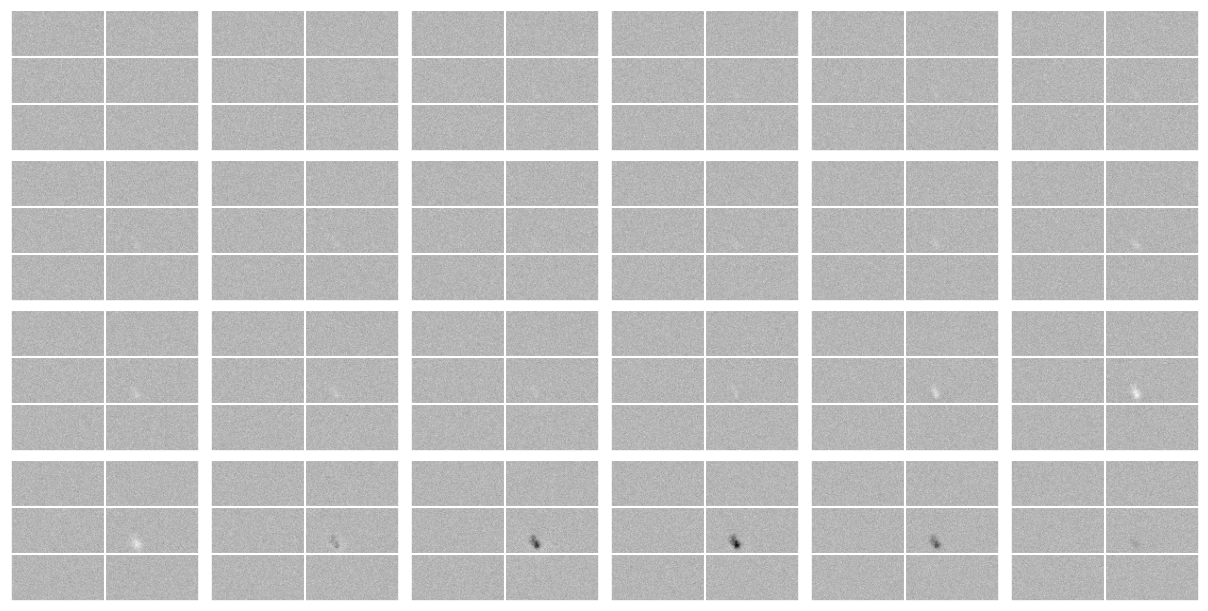

In [48]:
fig, axes = plt.subplots(nrows=4, ncols=kernel_size//4, constrained_layout=True, figsize=(kernel_size//2, 6),
                         sharex="all", sharey="all")
for a, ax in enumerate(axes.flatten()):
    ax.imshow(sta[a, :, :], cmap='gray', vmin=sta.min(), vmax=sta.max())
    ax.set(xticklabels=[], yticklabels=[])
    ax.tick_params(left=False, bottom=False)
plt.show()

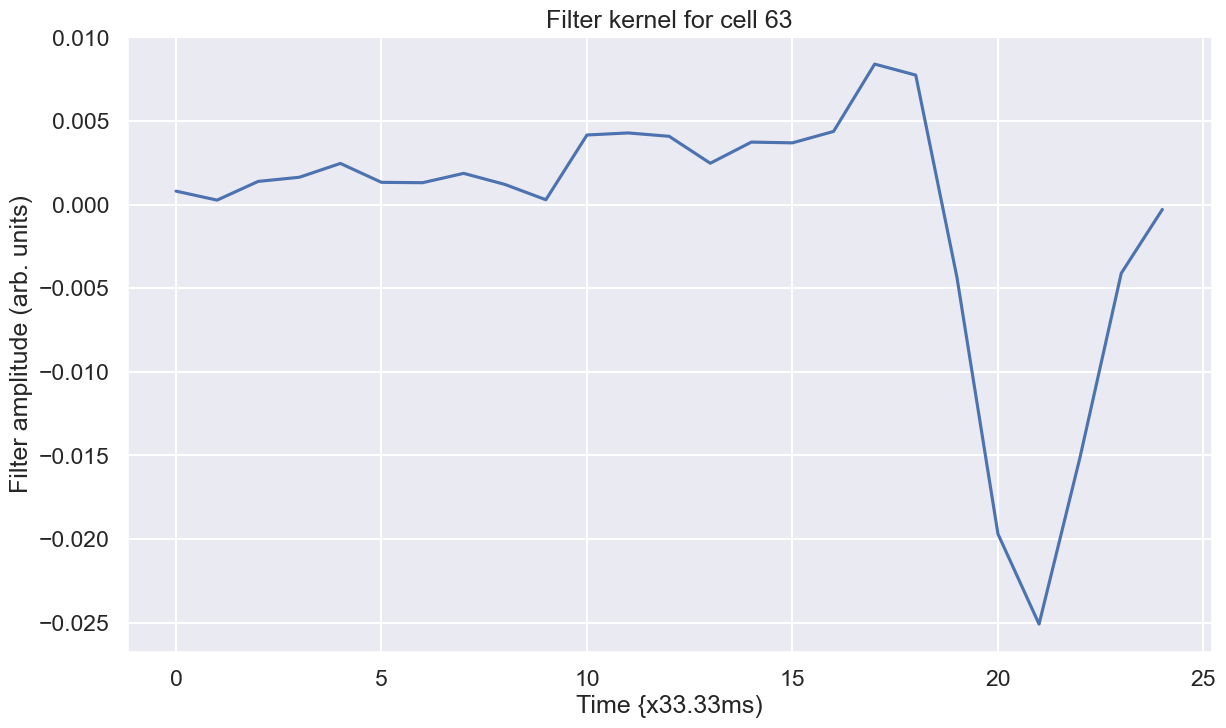

In [50]:
plt.close()
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(sta[:, mis_pos[1], mis_pos[2]])
ax.set_xlabel("Time {x33.33ms)")
ax.set_ylabel("Filter amplitude (arb. units)")
ax.set_title(f"Filter kernel for cell {cell_id}")
plt.show()

### Estimate non-linearity

In [48]:
t_, y_, x_ = mis_pos[0], mis_pos[1], mis_pos[2]

In [49]:
# np.sign corrects for a negative or positive MIS
spat_kern = np.sign(mis_val) * sta[t_, y_ - sta_window:y_ + sta_window, x_ - sta_window:x_ + sta_window].flatten()
spat_kern /= np.linalg.norm(spat_kern)

temp_kern = sta[:, mis_pos[1], mis_pos[2]].flatten()[::-1]
temp_kern /= np.linalg.norm(temp_kern)

In [50]:
convolved = convolve_stimulus_with_kernels(stimuli, spat_kern, temp_kern, running.shape[1], x_, y_, sta_window)

Trials:   0%|          | 0/219 [00:00<?, ?it/s]

In [51]:
convolved.shape

(219, 1476)

In [73]:
# c_bins = get_quantile_bins(convolved, 250)
c_bins = np.linspace(convolved.min(), convolved.max(), 141)
c_bin_ids = np.digitize(convolved, c_bins)

In [74]:
xs = (c_bins[1:] + c_bins[:-1]) / 2

In [75]:
avg_spk_cts_per_bin = np.zeros(c_bins.size)
for b, cbin in enumerate(c_bins):
    bin_id_pos = np.where(c_bin_ids == b)
    num_bins = bin_id_pos[0].size
    if num_bins > 0:
        trial_pos, bin_pos = bin_id_pos
        bin_pos += kernel_size - 1
        avg_spk_cts_per_bin[b] = np.mean(cell_response[trial_pos, bin_pos])

In [77]:
cell_response.shape

(219, 1500)

In [83]:
params, covs = curve_fit(softmax_model, convolved.ravel(), cell_response[:, kernel_size-1:].ravel())

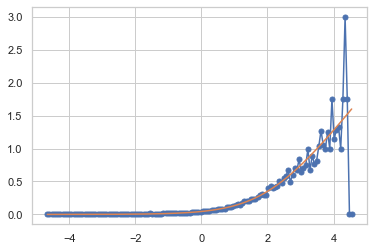

In [85]:
fig, ax = plt.subplots()
ax.plot(xs, avg_spk_cts_per_bin[1:], marker='o', ms=5)
ax.plot(xs, softmax_model(xs, *params))
plt.show()

### Predict response to frozen stimulus

In [58]:
frozen_resp = frozen[cell_id]

In [59]:
frozen_resp.shape

(219, 300)

In [60]:
frozen_stim = np.load(os.path.join(stimuli_path, "frozen_stimuli.npy"))

In [61]:
frozen_stim.shape

(300, 150, 200)

In [62]:
frozen_stim = np.expand_dims(frozen_stim, axis=0)

In [63]:
print("(#trials, #bins, #height, #width)")
print(frozen_stim.shape)

(#trials, #bins, #height, #width)
(1, 300, 150, 200)


In [64]:
f_convolved = convolve_stimulus_with_kernels(frozen_stim, spat_kern, temp_kern, 1, x_, y_, sta_window)

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

In [65]:
f_convolved.shape

(1, 276)

In [66]:
predicted = get_predicted_response(f_convolved[0], c_bins, avg_spk_cts_per_bin, "fit", dimos_model)

In [67]:
predicted.shape

(276,)

In [68]:
calculated = np.mean(frozen_resp, axis=0)[kernel_size - 1:]

In [69]:
calculated.shape

(276,)

In [70]:
r, p = pearsonr(calculated, predicted)

In [71]:
xlist = np.arange(kernel_size - 1, frozen_stim.shape[1])

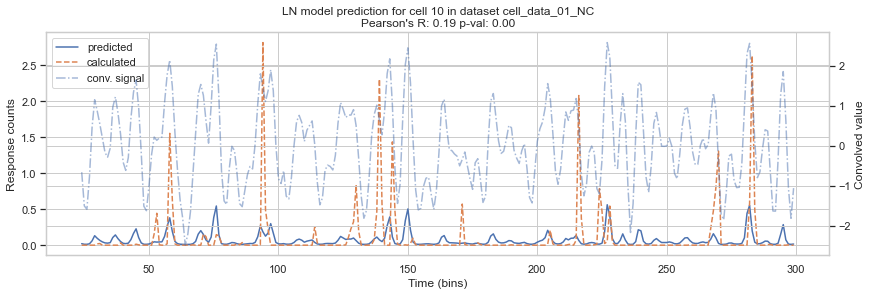

In [72]:
fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
p1, = ax.plot(xlist, predicted, label="predicted")
p2, = ax.plot(xlist, calculated, ls='--', label="calculated")

twin = ax.twinx()
p3, = twin.plot(xlist, f_convolved[0], ls='-.', alpha=0.5, label="conv. signal")

ax.set_xlabel("Time (bins)")
ax.set_ylabel("Response counts")
twin.set_ylabel("Convolved value")
ax.set_title(f"LN model prediction for cell {cell_id} in dataset {dataset}\nPearson's R: {r:.2f} p-val: {p:.2f}")
ax.legend(handles=[p1, p2, p3])
plt.show()

In [95]:
pred_lesser = get_predicted_response(f_convolved[0], c_bins, avg_spk_cts_per_bin, method="lesser")
rl, pl = pearsonr(pred_lesser, calculated)
pred_greater = get_predicted_response(f_convolved[0], c_bins, avg_spk_cts_per_bin, method="greater")
rg, pg = pearsonr(pred_greater, calculated)
pred_avg = get_predicted_response(f_convolved[0], c_bins, avg_spk_cts_per_bin, method="average")
ra, pa = pearsonr(pred_avg, calculated)
pred_fit = get_predicted_response(f_convolved[0], c_bins, avg_spk_cts_per_bin, method="fit", fit_func=dimos_model)
rf, pf = pearsonr(pred_fit, calculated)

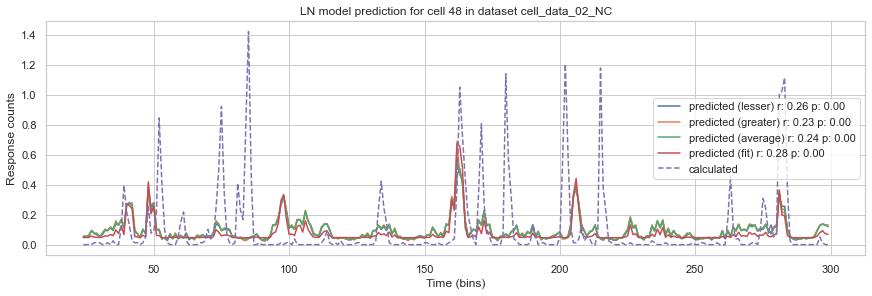

In [96]:
fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
ax.plot(xlist, pred_lesser, label=f"predicted (lesser) r: {rl:.2f} p: {pl:.2f}")
ax.plot(xlist, pred_greater, label=f"predicted (greater) r: {rg:.2f} p: {pg:.2f}")
ax.plot(xlist, pred_avg, label=f"predicted (average) r: {ra:.2f} p: {pa:.2f}")
ax.plot(xlist, pred_fit, label=f"predicted (fit) r: {rf:.2f} p: {pf:.2f}")
ax.plot(xlist, calculated, ls='--', label="calculated")
ax.set_xlabel("Time (bins)")
ax.set_ylabel("Response counts")
ax.set_title(f"LN model prediction for cell {cell_id} in dataset {dataset}")
plt.legend()
try:
    plt.savefig(f"./prediction_plots/{dataset}/cell_{cell_id}.png", dpi=300, bbox_inches="tight")
except FileNotFoundError:
    os.makedirs(f"./prediction_plots/{dataset}")
    plt.savefig(f"./prediction_plots/{dataset}/cell_{cell_id}.png", dpi=300, bbox_inches="tight")
plt.show()